# Data Exploration

In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
from ipywidgets import interact, widgets
import matplotlib.pyplot as plt
import seaborn as sns

## CO2 Total by Country (Yearly)

### Raw Data / Pathway

In [2]:
CO2_yearly_path = "../raw_data/CO2_YEARLY_DATA_1970-2021.xlsx"

As the data is very clean already this looks like a good framework to use for the other datasets which are very similar to this one.

In [3]:
# Removed the first rows that have no relevance and reset the index.
df_year = pd.read_excel(CO2_yearly_path, sheet_name="TOTALS BY COUNTRY", skiprows=[0, 1, 2, 3, 4, 5, 6, 7, 8], header=1) 
df_year.head(2)

,IPCC_annex,C_group_IM24_sh,Country_code_A3,Name,Substance,Y_1970,Y_1971,Y_1972,Y_1973,Y_1974,...,Y_2012,Y_2013,Y_2014,Y_2015,Y_2016,Y_2017,Y_2018,Y_2019,Y_2020,Y_2021
0,Non-Annex_I,Rest Central America,ABW,Aruba,CO2,95.065424,94.503709,105.847814,109.863856,99.977179,...,1637.822831,1605.689731,1633.584420,1626.234050,1597.398255,1335.792882,1366.614574,1404.705123,1166.018409,1295.818804
1,Non-Annex_I,India +,AFG,Afghanistan,CO2,3343.054709,3318.411036,3545.865063,3592.563616,4075.638761,...,14462.288815,12796.268484,12478.108782,12551.087669,11760.799383,12117.693742,12736.811832,12215.717086,12525.011330,12553.576369


In [4]:
df_year_fixed = df_year.drop(['IPCC_annex', 'IPCC_annex', 'Name', 'C_group_IM24_sh', 'Substance'], axis=1)
df_year_fixed.columns = [c.removeprefix("Y_") for c in df_year_fixed.columns]

In [5]:
countries_of_interest = ['AUS', 'BRA', 'CAN', 'CHN', 'DEU', 'GBR', 'FRA', 'IND', 'ISR', 'JPN', 'NGA', 'USA', 'ZWE']

In [6]:
df_year_filtered = df_year_fixed[df_year_fixed['Country_code_A3'].isin(countries_of_interest)].head(len(countries_of_interest))
df_year_filtered = df_year_filtered.reset_index(drop=True)

In [7]:
df = pd.DataFrame(np.array(df_year_filtered.columns[2:], dtype='int16'), columns=['year'])

In [8]:
for i in range(df_year_filtered.shape[0]):
    name: str = str(df_year_filtered.at[i, 'Country_code_A3'])
    df[name] = df_year_filtered.iloc[i, 2:].values.tolist()
df.head(2)

,year,AUS,BRA,CAN,CHN,DEU,FRA,GBR,IND,ISR,JPN,NGA,USA,ZWE
0,1971,212598.582320,346095.812829,421581.864558,1.611013e+06,1.091619e+06,525966.793044,679246.488804,760433.425800,15122.959675,871222.711232,174956.835911,4.821343e+06,29673.548342
1,1972,217361.948111,361043.688156,439879.240264,1.688336e+06,1.118686e+06,544331.953747,657224.914085,773179.176449,15977.416519,917322.377453,189459.501847,5.077198e+06,29766.298063


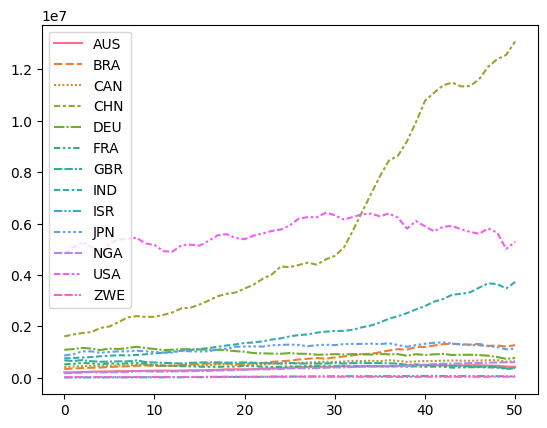

In [9]:
sns.lineplot(df[df.columns[1:]]);

In [10]:
@interact
def by_country(country=df.columns[1:]):
    sns.regplot(data=df, x='year', y=country, ci=95)
    plt.title(country)
    plt.show()

interactive(children=(Dropdown(description='country', options=('AUS', 'BRA', 'CAN', 'CHN', 'DEU', 'FRA', 'GBR'…

## ARIMA

In [11]:
arima = df.copy()

In [12]:
arima['year'] = pd.to_datetime(arima['year'], format='%Y')
arima.set_index('year', inplace=True)

### Stationarity check

In [13]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.stattools import adfuller

In [14]:
decompose_method = ['additive', 'multiplicative', 'stl']

In [15]:
from pmdarima.arima.utils import ndiffs

%matplotlib inline
@interact
def stationarity_plot(country=arima.columns, model=decompose_method):
    
    display(f'the dataset needs d = {ndiffs(arima[country])}')
    
    if model == 'stl':
        decompose = STL(arima[country]).fit()
    else:
        decompose = seasonal_decompose(x=arima[country], model=model)
    decompose.plot()

interactive(children=(Dropdown(description='country', options=('AUS', 'BRA', 'CAN', 'CHN', 'DEU', 'FRA', 'GBR'…

### Hyperparameters choice

In [16]:
import warnings
from statsmodels.tools.sm_exceptions import ValueWarning, ConvergenceWarning
warnings.simplefilter('ignore', ValueWarning)
warnings.simplefilter('ignore', ConvergenceWarning)
warnings.simplefilter('ignore', UserWarning)

In [17]:
test_size = 9

In [18]:
arima_train = arima.iloc[:-test_size, :]
arima_test = arima.iloc[-test_size:, :]

In [19]:
import pmdarima as pm

horizon=12

@interact
def arima_auto_parameters_search(country=arima_train.columns):
    return pm.auto_arima(arima_train[country],
                         start_p=0, max_p=5,
                         start_q=0, max_q=5,
                         max_order=20,
                         trend=None,
                         seasonal=False,
                         n_jobs=-1,
                         trace=True,
                         alpha=0.05,
                         scoring='mae')



interactive(children=(Dropdown(description='country', options=('AUS', 'BRA', 'CAN', 'CHN', 'DEU', 'FRA', 'GBR'…

### Prediction

In [20]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_predict

In [21]:
size = arima.shape[0] - 1

In [28]:
@interact
def plot(country=arima.columns, 
         trend=[None, 'c', 't', 'ct'],
         p=widgets.IntSlider(min=0, max=5, step=1, value=0),
         d=widgets.IntSlider(min=0, max=3, step=1, value=0),
         q=widgets.IntSlider(min=0, max=5, step=1, value=0)):
    model = ARIMA(arima_train[country], order=(p, d, q), trend=trend).fit()
    fig, axs = plt.subplots(1, 1, figsize=(12, 5))
    axs.plot(arima[country], label=country)
    axs.set_title(f'{country}, trend: {trend}, p={p}, d={d}, q={q}')
    plot_predict(model, start=size-test_size, end=size, ax=axs);

interactive(children=(Dropdown(description='country', options=('AUS', 'BRA', 'CAN', 'CHN', 'DEU', 'FRA', 'GBR'…